# Dataset Statistics for Disease Gene Sentences

This notebook is designed to show statistics on the data extracted from pubmed. The following cells below here are needed to set up the environment.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import Counter
from itertools import product
import os
import pickle
import sys

sys.path.append(os.path.abspath('../../../modules'))

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.models import candidate_subclass, Candidate
DiseaseGene = candidate_subclass('DiseaseGene', ['Disease', 'Gene'])

In [4]:
from utils.notebook_utils.dataframe_helper import write_candidates_to_excel

# Read Full Sentence Table

The cells below will read every sentence that contains a gene and disease entity from the sentence table in our postgres database. For time sake majority of the data has already been processed and save as files mentioned below.

In [ ]:
sql = '''
select id, text, entity_cids, entity_types 
from sentence 
where entity_types::text like '%%Gene%%' or entity_types::text like '%%Disease%%';
'''
sentence_df = pd.read_sql(sql, database_str)
sentence_df.head(2)

In [ ]:
records = []
for index, row in tqdm_notebook(sentence_df.iterrows()):
    entity_record = Counter([x for x in row['entity_types'] if x !='O'])
    entity_record.update({'sentence_id':row['id']})
    records.append(dict(entity_record))
sentence_stats_df = pd.DataFrame.from_records(records).fillna(0)
sentence_stats_df.to_csv("data/sentence_stats.tsv.xz", sep="\t",  index=False)

In [ ]:
entity_counts = Counter()
for index, row in tqdm_notebook(sentence_df.iterrows()):
    entity_counts.update([x for x in row['entity_cids'] if x!='O'])
sentence_stats_df = pd.DataFrame.from_dict(records).fillna(0)
sentence_stats_df.to_csv("data/entity_stats.tsv.xz", sep="\t",  index=False)

# Stratified Sentence Counts and Statistics

Below are the counts of sentences that contain a co-occuring pair in and not in hetionet. Sentences can contain multiple co=ccuring pairs, so these results do have single sentences counted multiple times.

In [5]:
entity_level_df = pd.read_csv("../disease_gene_pairs_association.csv.xz")
entity_level_df.head(2)

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,entrez_gene_id,gene_symbol,doid_id,doid_name,sources,hetionet,n_sentences,has_sentence,partition_rank,split
0,1,A1BG,DOID:2531,hematologic cancer,NaN,0,8,1,0.85860,1
1,1,A1BG,DOID:1319,brain cancer,NaN,0,0,0,0.36785,0


In [6]:
print(
    "Number of sentences in train set with entity pairs in hetionet: {}"
    .format(
        entity_level_df.query("split==0&has_sentence==1&hetionet==1").n_sentences.sum()
    )
)
print(
    "Number of sentences in train set with entity pairs not in hetionet: {}"
    .format(
        entity_level_df.query("split==0&has_sentence==1&hetionet==0").n_sentences.sum()
    )
)

Number of sentences in train set with entity pairs in hetionet: 1367767
Number of sentences in train set with entity pairs not in hetionet: 1299837


In [7]:
print(
    "Number of sentences in dev set with entity pairs in hetionet: {}"
    .format(
        entity_level_df.query("split==1&has_sentence==1&hetionet==1").n_sentences.sum()
    )
)
print(
    "Number of sentences in dev set with entity pairs not in hetionet: {}"
    .format(
        entity_level_df.query("split==1&has_sentence==1&hetionet==0").n_sentences.sum()
    )
)

Number of sentences in dev set with entity pairs in hetionet: 449081
Number of sentences in dev set with entity pairs not in hetionet: 367965


In [8]:
print(
    "Number of sentences in test set with entity pairs in hetionet: {}"
    .format(
        entity_level_df.query("split==2&has_sentence==1&hetionet==1").n_sentences.sum()
    )
)
print(
    "Number of sentences in test set with entity pairs not in hetionet: {}"
    .format(
        entity_level_df.query("split==2&has_sentence==1&hetionet==0").n_sentences.sum()
    )
)

Number of sentences in test set with entity pairs in hetionet: 172399
Number of sentences in test set with entity pairs not in hetionet: 173069


# Co-occuring Mentions Sentence Stats

This next block contains visualizations for the distribution of mentions occuring in a given sentence. These visualizations are heatmaps that represent the counts of sentences that fall into certain mention groups

In [9]:
sentence_stats_df = pd.read_table("data/sentence_stats.tsv.xz")

In [10]:
sentence_sql = '''
select cand_id, "Disease_cid", "Gene_cid", sentence_id from (
select disease_gene.id as "cand_id", disease_gene."Disease_id",  disease_gene."Disease_cid", disease_gene."Gene_cid", candidate.split from disease_gene 
inner join candidate on disease_gene.id=candidate.id 
where split={}
) as candidate_splits inner join span on candidate_splits."Disease_id"=span.id;
'''
train_candidate_df = pd.read_sql(sentence_sql.format(0), database_str)
dev_candidate_df = pd.read_sql(sentence_sql.format(1), database_str)
test_candidate_df = pd.read_sql(sentence_sql.format(2), database_str)

In [11]:
clean_up_df = lambda x: (
        sentence_stats_df
        .merge(x, on="sentence_id")
        .rename(index=str, columns={
            "Disease":"Disease_mention_count", 
            "Gene":"Gene_mention_count", 
            "Compound":"Compound_mention_count",
            "cand_id": "candidate_id",
            "Disease_cid": "doid_id",
            "Gene_cid": "entrez_gene_id"
        })
    )

In [12]:
train_candidate_df = clean_up_df(train_candidate_df)
dev_candidate_df = clean_up_df(dev_candidate_df)
test_candidate_df = clean_up_df(test_candidate_df)

In [13]:
train_candidate_df.head(2)

,sentence_id,Disease_mention_count,Gene_mention_count,Compound_mention_count,candidate_id,doid_id,entrez_gene_id
0,100000099,1.0,4.0,1.0,35413088,DOID:3070,9211
1,100000099,1.0,4.0,1.0,35413094,DOID:3070,9211


Text(0.5,1,'Sentence Distribution of Entire Training Dataset')

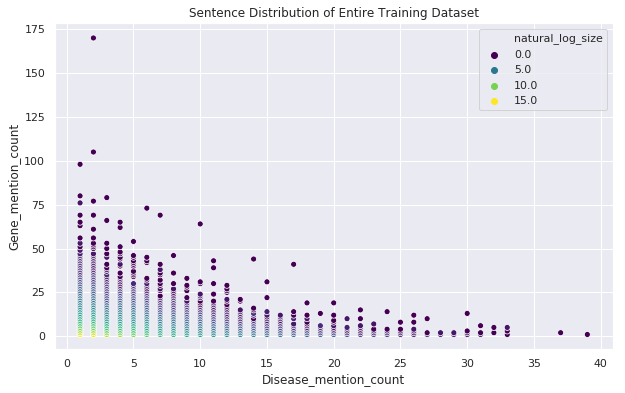

In [14]:
sns.set(rc={'figure.figsize':(10,6)})
ax = sns.scatterplot(
    x="Disease_mention_count", 
    y="Gene_mention_count", 
    data=
    (
        train_candidate_df
        .drop_duplicates("sentence_id")
        .groupby(["Disease_mention_count", "Gene_mention_count"]).size()
        .reset_index()
        .rename(index=str, columns={0:"size"})
        .assign(natural_log_size= lambda x: pd.np.log(x['size']))
    ),
    hue="natural_log_size",
    palette='viridis'
)
ax.set_title("Sentence Distribution of Entire Training Dataset")

Notice that there are a few outliers, especially one that contains a total of 175 gene mentions in one sentence. Upon closer inspection this sentence is actually a listing of abbreviations that could be removed to filter out a bit of noise.

Text(0.5,1,'Sentence Distribution of Entire Dev Dataset')

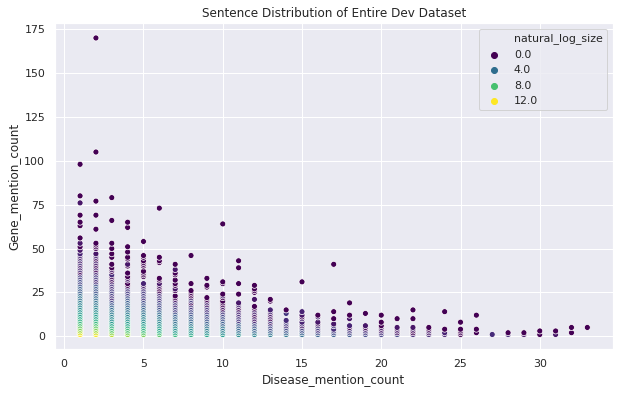

In [15]:
sns.set(rc={'figure.figsize':(10,6)})
ax = sns.scatterplot(
    x="Disease_mention_count", 
    y="Gene_mention_count", 
    data=
    (
        dev_candidate_df
        .drop_duplicates("sentence_id")
        .groupby(["Disease_mention_count", "Gene_mention_count"]).size()
        .reset_index()
        .rename(index=str, columns={0:"size"})
        .assign(natural_log_size= lambda x: pd.np.log(x['size']))
    ),
    hue="natural_log_size",
    palette='viridis'
)
ax.set_title("Sentence Distribution of Entire Dev Dataset")

In [16]:
candidate_files = zip(
    [train_candidate_df, dev_candidate_df, test_candidate_df], 
    ["data/train_sentence_stats.tsv.xz", "data/dev_sentence_stats.tsv.xz", "data/test_sentence_stats.tsv.xz"]
)

for dataframe, file in candidate_files:
    dataframe.to_csv(file, sep="\t", index=False, compression='xz')

# Subsampled Set Distributions

In [17]:
train_dataset_df = pd.read_excel("sentence_labels_train.xlsx")
dev_dataset_df = pd.read_excel("sentence_labels_dev.xlsx").query("curated_dsh.notnull()")
test_dataset_df = pd.read_excel("sentence_labels_test.xlsx").query("curated_dsh.notnull()")

In [18]:
train_candidates_stats_df = (
    train_candidate_df
    .merge(train_dataset_df[["candidate_id"]], on="candidate_id")
)

dev_candidates_stats_df = (
    dev_candidate_df
    .merge(dev_dataset_df[["candidate_id"]], on="candidate_id")
)

test_candidates_stats_df = (
    train_candidate_df
    .merge(test_dataset_df, on="candidate_id")
)

Text(0.5,1,'Distribution of Sentences in Subsampled Training Set')

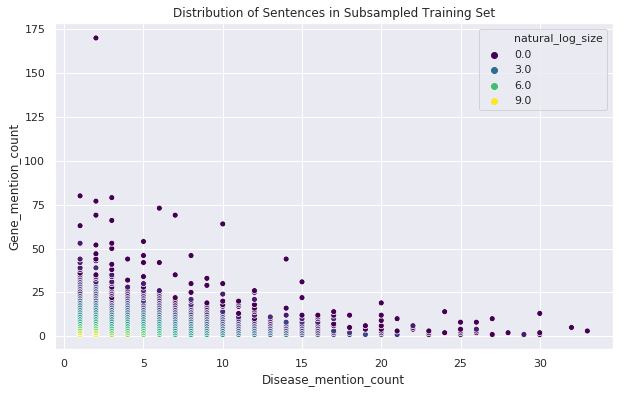

In [19]:
sns.set(rc={'figure.figsize':(10,6)})
ax = sns.scatterplot(
    x="Disease_mention_count", 
    y="Gene_mention_count", 
    data=
    (
        train_candidates_stats_df
        .drop_duplicates("sentence_id")
        .groupby(["Disease_mention_count", "Gene_mention_count"]).size()
        .reset_index()
        .rename(index=str, columns={0:"size"})
        .assign(natural_log_size= lambda x: pd.np.log(x['size']))
    ),
    hue="natural_log_size",
    palette='viridis'
)
ax.set_title("Distribution of Sentences in Subsampled Training Set")

Text(0.5,1,'Sentence Distribution of Hand Labeled Dev Dataset')

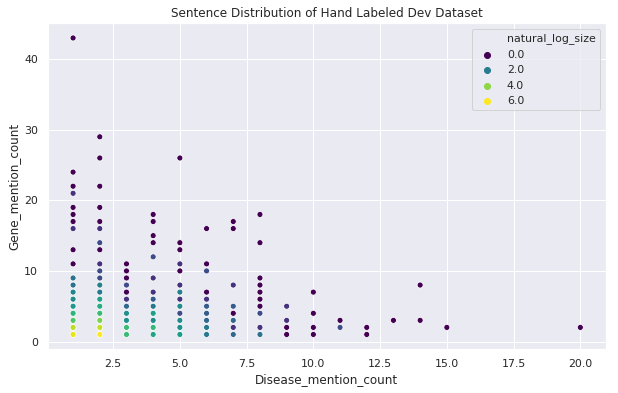

In [20]:
sns.set(rc={'figure.figsize':(10,6), 'font.size':30})
ax = sns.scatterplot(
    x="Disease_mention_count", 
    y="Gene_mention_count", 
    data=
    (
        dev_candidates_stats_df
        .drop_duplicates("sentence_id")
        .groupby(["Disease_mention_count", "Gene_mention_count"]).size()
        .reset_index()
        .rename(index=str, columns={0:"size"})
        .assign(natural_log_size= lambda x: pd.np.log(x['size']))
    ),
    hue="natural_log_size",
    palette='viridis'
)
ax.set_title("Sentence Distribution of Hand Labeled Dev Dataset")

In [21]:
dev_dataset_df.curated_dsh.value_counts()

0.0    662
1.0    338
Name: curated_dsh, dtype: int64